In [1]:
import numpy as np
import torch
import open_clip
import csv
from tqdm import tqdm
import pandas
import matplotlib.pyplot as plt

/home/martin/Documents/MScProject/project_local/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
testsets = {
    "Progan" : ["progan_lsun"],
    "Biggan" : ["biggan_256","biggan_512"],
    "Gaugan" : ["gaugan"],
    "Stargan" : ["stargan"],
    "EG3D" : ["eg3d"],
    "Stylegan 2": ["stylegan2_afhqv2_512x512",
                   "stylegan2_ffhq_256x256",
                   "stylegan2_ffhq_1024x1024",
                   "stylegan2_lsundog_256x256",
                   "whichfaceisreal"],
    "Stylegan 3" : ["stylegan3_r_afhqv2_512x512",
                    "stylegan3_r_ffhqu_256x256",
                    "stylegan3_r_ffhqu_1024x1024",
                    "stylegan3_t_afhqv2_512x512",
                    "stylegan3_t_ffhqu_256x256",
                    "stylegan3_t_ffhqu_1024x1024"],
    "Taming Trans." : ["taming-transformers_class2image_ImageNet",
                             "taming-transformers_noise2image_FFHQ",
                             "taming-transformers_segm2image_valid"],
    "Dall-E Mini" : ["dalle-mini_valid"],
    "Dall-E 2" : ["dalle_2"],
    "Glide" : ["glide_text2img_valid"],
    "Guided Dif." : ["guided-diffusion_class2image_ImageNet",  
                "guided-diffusion_noise2image_LSUNbedrooms",
                "guided-diffusion_noise2image_LSUNcats",
                "guided-diffusion_noise2image_LSUNhorses"],
    "Latent Dif." : ["latent-diffusion_class2image_ImageNet",
                          "latent-diffusion_noise2image_FFHQ",
                          "latent-diffusion_noise2image_LSUNbedrooms",
                          "latent-diffusion_noise2image_LSUNchurches",
                          "latent-diffusion_text2img_valid"],
    "Stable Diff." : ["stable_diffusion_256"],
    "Stable Diff. v2" : ["stable_diffusion_512_50steps",
                             "stable_diffusion_512_100steps",
                             "stable_diffusion_512_200steps"],
    "DeepFakes" : ["deepfake"],
    "Pristine" : ["real_coco_valid", 
                  "real_imagenet_val", 
                  "real_ucid",
                  "ffhq",
                  "celebA",
                  ],
}

In [3]:
progan_openai_model1 = pandas.read_csv("data/progan-trained/vitL14_progan_openai_720k_net_accuracies.csv", header=0, index_col=0)
progan_openai_model2 = pandas.read_csv("data/ablation/progan_openai_model2.csv", header=0, index_col=0)
progan_openai_model3 = pandas.read_csv("data/ablation/progan_openai_model3.csv", header=0, index_col=0)
progan_openai_blip_model1 = pandas.read_csv("data/progan-trained/vitL14_progan_openai+BLIP_100k_net_accuracies.csv", header=0, index_col=0)
progan_openai_blip_model2 = pandas.read_csv("data/ablation/progan_openai+BLIP_model2.csv", header=0, index_col=0)
progan_openai_blip_model3 = pandas.read_csv("data/ablation/progan_openai+BLIP_model3.csv", header=0, index_col=0)
progan_stable_laion_model1 = pandas.read_csv("data/fuse/progan+stable_vitH14_200k_laion_net_accuracy.csv", header=0, index_col=0)
progan_stable_laion_model2 = pandas.read_csv("data/ablation/progan+stable_laion_model2.csv", header=0, index_col=0)
progan_stable_laion_model3 = pandas.read_csv("data/ablation/progan+stable_laion_model3.csv", header=0, index_col=0)

models = [
        "Progan OpenAI LC 1",
        "Progan OpenAI LC 2",
        "Progan OpenAI LC 3",
        "Progan OpenAI+BLIP LC 1",
        "Progan OpenAI+BLIP LC 2",
        "Progan OpenAI+BLIP LC 3",
        "FUSED LAION LC 1",
        "FUSED LAION LC 2",
        "FUSED LAION LC 3",
        ]
colors = {
        "Progan OpenAI LC 1": "gold",
        "Progan OpenAI LC 2": "orange",
        "Progan OpenAI LC 3": "red",
        "Progan OpenAI+BLIP LC 1": "gold",
        "Progan OpenAI+BLIP LC 2": "orange",
        "Progan OpenAI+BLIP LC 3": "red",
        "FUSED LAION LC 1": "gold",
        "FUSED LAION LC 2": "orange",
        "FUSED LAION LC 3": "red",
}

allsubmodels = []
for key in testsets:
    allsubmodels = allsubmodels + testsets[key]
tab_metrics = pandas.DataFrame(index=list(allsubmodels), columns = models)

for key in allsubmodels:
    tab_metrics.loc[key, "Progan OpenAI LC 1"] = progan_openai_model1.loc[key + ".pt", "0.30"]
    tab_metrics.loc[key, "Progan OpenAI LC 2"] = progan_openai_model2.loc[key + ".pt", "0.30"]
    tab_metrics.loc[key, "Progan OpenAI LC 3"] = progan_openai_model3.loc[key + ".pt", "0.30"]

    tab_metrics.loc[key, "Progan OpenAI+BLIP LC 1"] = progan_openai_blip_model1.loc[key + ".pt", "0.30"]
    tab_metrics.loc[key, "Progan OpenAI+BLIP LC 2"] = progan_openai_blip_model2.loc[key + ".pt", "0.30"]
    tab_metrics.loc[key, "Progan OpenAI+BLIP LC 3"] = progan_openai_blip_model3.loc[key + ".pt", "0.30"]

    tab_metrics.loc[key, "FUSED LAION LC 1"] = progan_stable_laion_model1.loc[key + ".pt", "0.90"]
    tab_metrics.loc[key, "FUSED LAION LC 2"] = progan_stable_laion_model2.loc[key + ".pt", "0.90"]
    tab_metrics.loc[key, "FUSED LAION LC 3"] = progan_stable_laion_model3.loc[key + ".pt", "0.90"]

def plot_raw_accuracy(sets, models, width=0.30, multiplier=-1):
    plot_sets = sets
    plot_models = models

    x = np.arange(len(plot_sets))

    fig, ax = plt.subplots(layout='constrained')
    fig.set_size_inches(18.5, 3.0)

    for model in plot_models:
        measurement = []
        for set in plot_sets:
            subsets = testsets[set]
            m = np.mean([tab_metrics.loc[subset, model] for subset in subsets])
            measurement.append(m)
        measurement = tuple([m * 100 for m in measurement])
        offset = width * multiplier
        rects = ax.bar(x+offset, measurement, width, label=model, color=colors[model])
        multiplier += 1

    ax.set_ylabel("Accuracy")
    ax.set_xticks(x+width, plot_sets)
    ax.legend(loc='upper center', ncols=len(models))
    ax.set_ylim(0,115)
    ax.axhline(y = 100, color = 'black', linestyle = '-')

    plt.show()

def plot_mean_accuracy(sets, models, width=0.30, multiplier=-1):
    plot_sets = sets
    plot_models = models

    x = np.arange(len(plot_sets))

    fig, ax = plt.subplots(layout='constrained')
    fig.set_size_inches(18.5, 3.0)

    for model in plot_models:
        measurement = []
        for set in plot_sets:
            subsets = testsets[set]
            m = np.mean([tab_metrics.loc[subset, model] for subset in subsets])
            measurement.append(m)
        pristine_mean = np.mean([tab_metrics.loc[subset, model] for subset in testsets["Pristine"]])
        measurement = [(m+pristine_mean)/ 2 * 100 for m in measurement]
        GAN_accuracy = np.mean(measurement[0:7])
        VQGAN_accuracy = np.mean(measurement[7:9])
        DM_accuracy = np.mean(measurement[7:-2])
        mean_accuracy = np.mean(measurement[:-1])
        print(f"{model} : GAN({GAN_accuracy}) VQGAN({VQGAN_accuracy} DM({DM_accuracy}) MEAN({mean_accuracy})")
        measurement = tuple(measurement)
        offset = width * multiplier
        rects = ax.bar(x+offset, measurement, width, label=model, color = colors[model])
        multiplier += 1

    ax.set_ylabel("Accuracy")
    ax.set_xticks(x+width, plot_sets)
    ax.set_ylim(0,115)
    ax.legend(loc='upper center', ncols=len(models))
    ax.axhline(y = 50, color = 'r', linestyle = '--')
    ax.axhline(y = 100, color = 'black', linestyle = '-')

    plt.show()
    

(100.0, 90.10000000000001, 100.0, 99.94997498749376, 97.3, 96.62041322759887, 80.9459394464084, 88.66666666666667, 83.3, 53.800000000000004, 74.3, 20.15416666666667, 54.12000000000001, 90.7, 33.050000000000004, 57.85767234988881, 89.33513675971018)
(100.0, 87.3, 99.92, 98.54927463731866, 96.39999999999999, 94.23879088669507, 76.53909049371137, 84.49999999999999, 80.10000000000001, 40.300000000000004, 57.599999999999994, 15.966666666666665, 49.28, 86.9, 31.06666666666667, 50.51890289103039, 88.75988836869854)
(99.9, 86.3, 99.9, 98.34917458729365, 95.8, 94.19980974986963, 78.54171175720847, 80.7, 73.5, 41.099999999999994, 50.7, 14.820833333333336, 48.760000000000005, 79.4, 26.616666666666667, 45.73758339510749, 87.51673211493639)


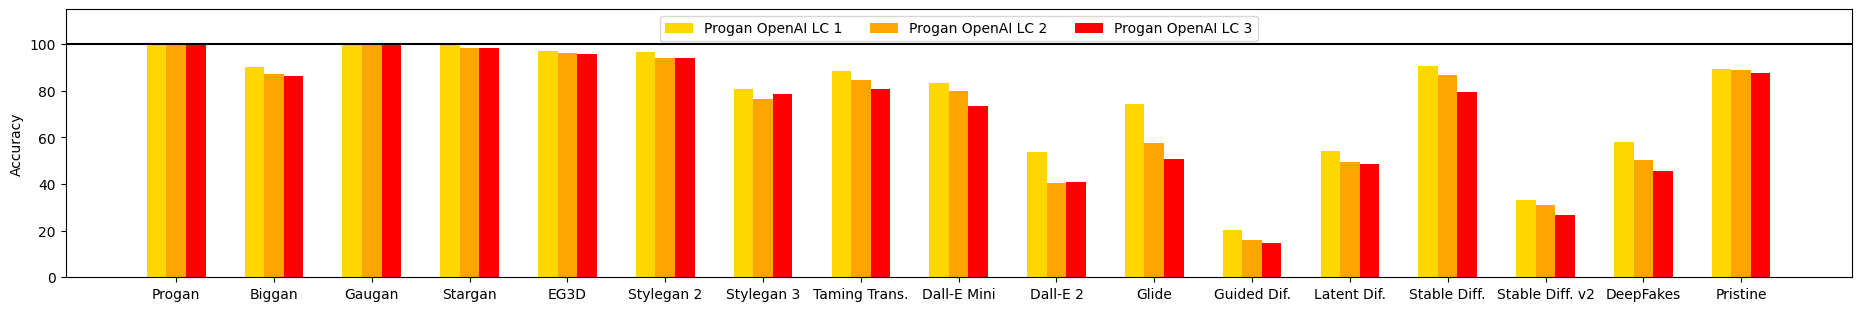

Progan OpenAI LC 1 : GAN(92.16159178424802) VQGAN(87.65923504652176 DM(77.88477076080747) MEAN(83.43447374634957)
Progan OpenAI LC 2 : GAN(91.01902675704393) VQGAN(85.52994418434926 DM(73.99756323196833) MEAN(81.00196049605123)
Progan OpenAI LC 3 : GAN(90.40055863563761) VQGAN(82.30836605746819 DM(71.54271129556344) MEAN(79.37797259394725)


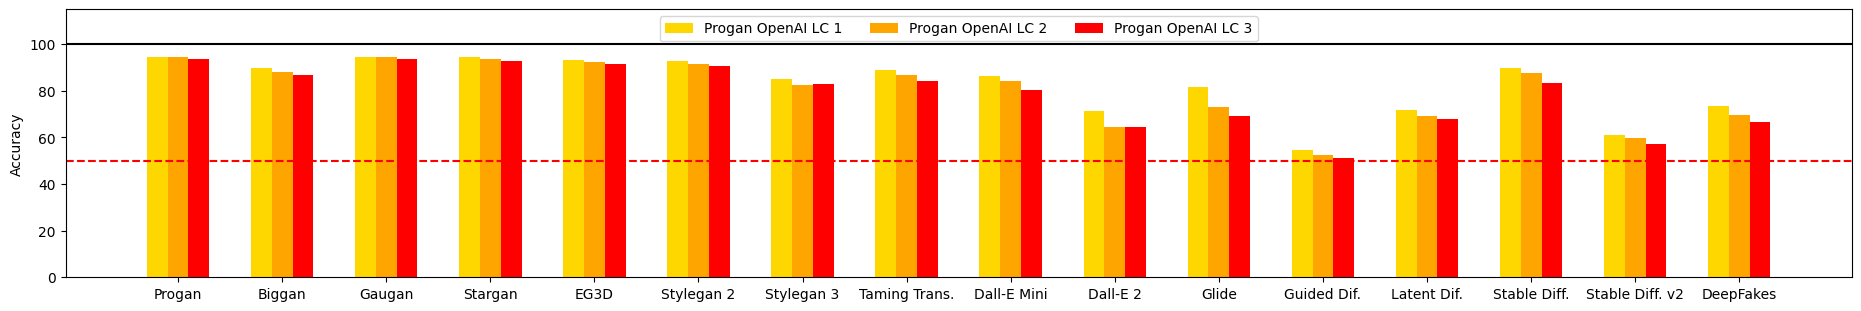

In [11]:
plot_sets = list(testsets.keys())
plot_models = ["Progan OpenAI LC 1", "Progan OpenAI LC 2", "Progan OpenAI LC 3"]

plot_raw_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

plot_sets = list(testsets.keys())[:-1]
plot_mean_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

(99.9, 89.8, 100.0, 99.89994997498748, 96.3, 95.92011220801638, 78.54171175720847, 87.56666666666666, 82.19999999999999, 44.2, 75.6, 16.683333333333334, 47.400000000000006, 91.8, 32.06666666666666, 60.711638250555964, 91.5012683591422)
(99.8, 86.3, 99.92, 98.24912456228114, 91.7, 93.29944867022711, 74.03566361253397, 81.19999999999999, 72.7, 33.900000000000006, 65.3, 15.216666666666667, 43.4, 85.2, 23.316666666666666, 55.3002223869533, 92.47228344665605)
(99.8, 83.1, 99.9, 98.99949974987494, 94.3, 94.13998921076765, 75.33066397325831, 79.5, 69.6, 34.9, 61.3, 13.1625, 42.18, 84.1, 24.28333333333333, 53.15048183839881, 90.4806124945881)


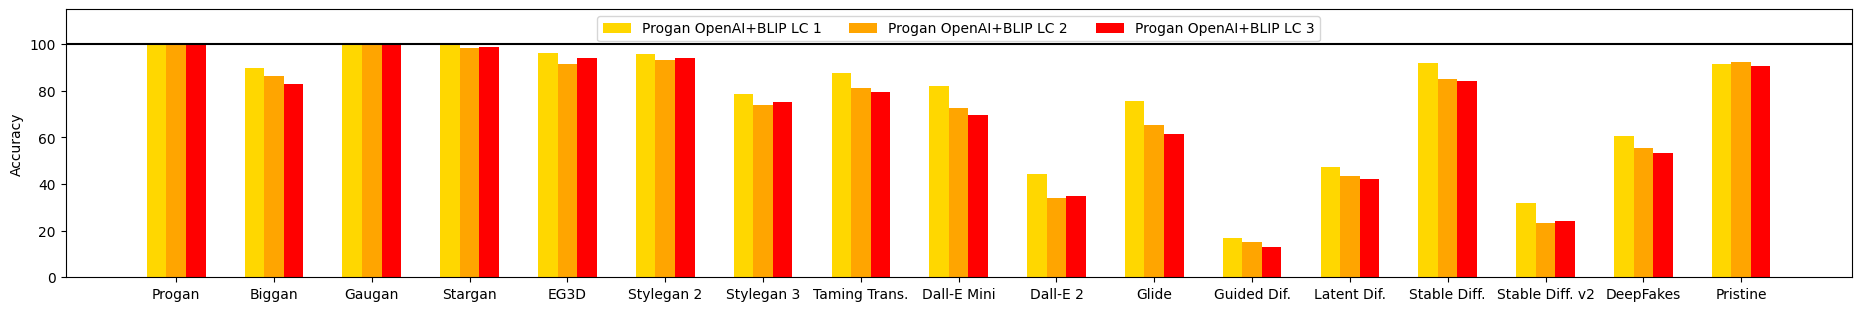

Progan OpenAI+BLIP LC 1 : GAN(92.91933231815769) VQGAN(88.19230084623777 DM(77.56849132242824) MEAN(83.67991553313372)
Progan OpenAI+BLIP LC 2 : GAN(92.18644435511673) VQGAN(84.71114172332803 DM(74.58733219951851) MEAN(81.6873940626072)
Progan OpenAI+BLIP LC 3 : GAN(91.35246002828698) VQGAN(82.51530624729403 DM(72.72191339015119) MEAN(80.39350578953517)


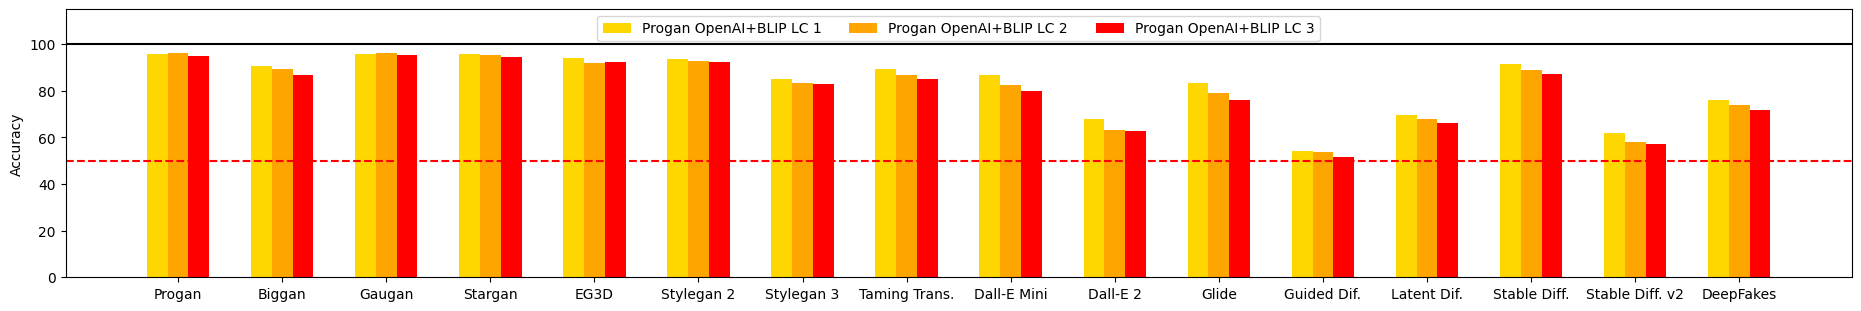

In [13]:
plot_sets = list(testsets.keys())
plot_models = ["Progan OpenAI+BLIP LC 1", "Progan OpenAI+BLIP LC 2", "Progan OpenAI+BLIP LC 3"]

plot_raw_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

plot_sets = list(testsets.keys())[:-1]
plot_mean_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

(98.8, 78.8, 95.39999999999999, 79.63981990995498, 83.1, 89.00729711747675, 81.13171247865715, 85.2, 93.8, 91.7, 67.5, 20.1, 56.82000000000001, 93.30000000000001, 86.81666666666666, 53.52112676056338, 82.76858744319841)
(99.1, 81.80000000000001, 95.84, 74.93746873436719, 77.2, 89.32406178633725, 77.13729168169685, 89.9, 96.1, 90.60000000000001, 74.4, 22.233333333333334, 64.32, 93.10000000000001, 91.88333333333333, 55.33728687916975, 82.62307698991498)
(98.7, 81.1, 96.04, 67.43371685842922, 77.10000000000001, 87.36495765226303, 76.33468003751533, 89.1, 95.3, 89.4, 72.1, 22.141666666666666, 63.480000000000004, 92.60000000000001, 91.36666666666667, 57.59822090437361, 82.97152998472329)


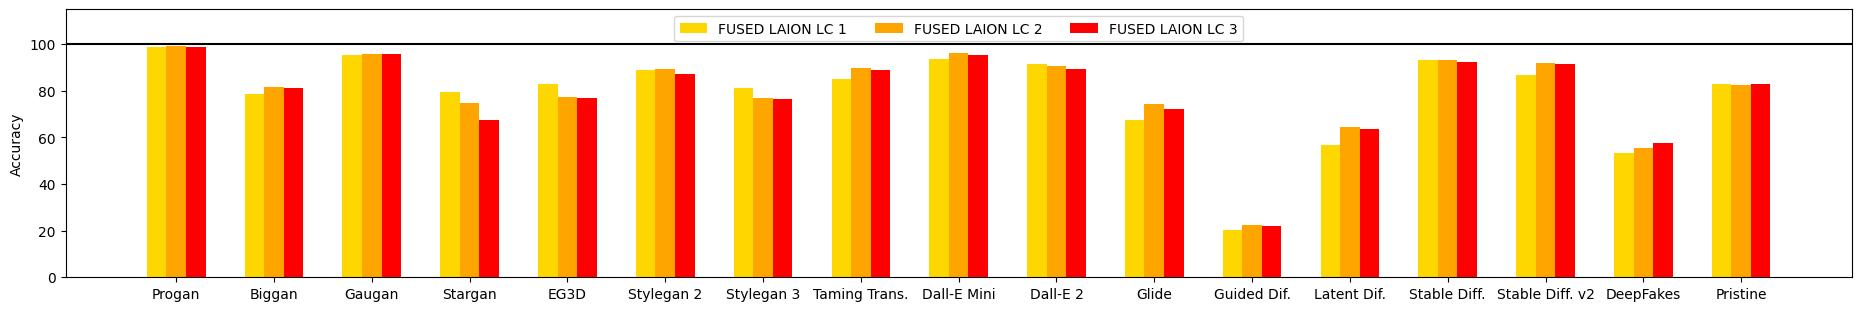

FUSED LAION LC 1 : GAN(84.66135297203414) VQGAN(86.1342937215992 DM(77.70000800731349) MEAN(81.42147692735774)
FUSED LAION LC 2 : GAN(83.8357400808433) VQGAN(87.81153849495749 DM(79.21534801876702) MEAN(81.90738812392642)
FUSED LAION LC 3 : GAN(83.20529031723363) VQGAN(87.58576499236165 DM(78.92302689712356) MEAN(81.471154588413)


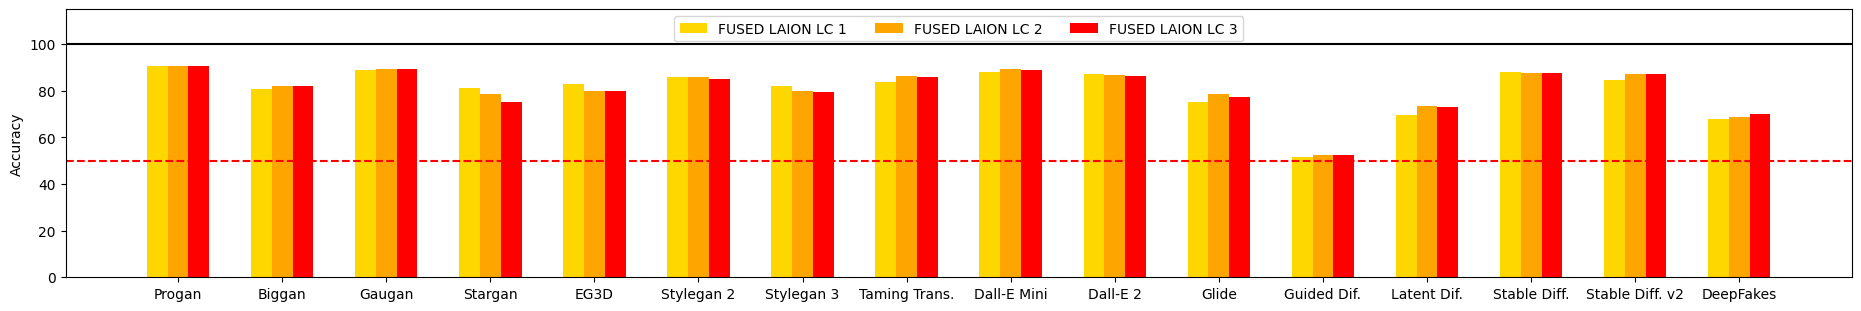

In [14]:
plot_sets = list(testsets.keys())
plot_models = ["FUSED LAION LC 1", "FUSED LAION LC 2", "FUSED LAION LC 3"]

plot_raw_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

plot_sets = list(testsets.keys())[:-1]
plot_mean_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)